### Processing handwritten equation with OpenCV

In [37]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt

In [38]:
image = cv.imread('sevenplusthree.png')
image_working_copy = image.copy()

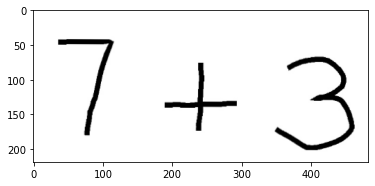

In [39]:
plt.imshow(image)

In [40]:
imgray = cv.cvtColor(image_working_copy, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

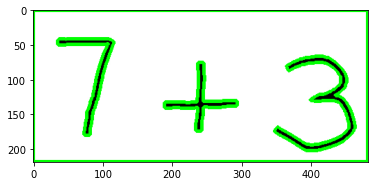

In [41]:
image_with_contours = cv.drawContours(image_working_copy, contours, -1, (0,255,0), 3)

plt.imshow(image_with_contours)

In [42]:
def find_contours(path):
    """
    Finds all contours in a given picture.
    Args:
        path (str): path to image
    Returns:
        contours: Detected contours. Each contour is stored as a vector of points.
        hierarchy: Optional output vector, containing information about the image topology.
    """
    img = cv.imread(path)
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(imgray, 127, 255, 0)
    return cv.findContours(
        thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [43]:
contours, hierarchy = find_contours('sevenplusthree.png')

In [44]:
# create list of tuples
boundingRects = [cv.boundingRect(contour) for contour in contours]

In [53]:
# sort list of tuples by first element (which is x coordinate), that way we get bounding boxes in right order 
boundingRects.sort()

In [94]:
#check
boundingRects = boundingRects[1:]

boundingRects

[(35, 41, 82, 140), (189, 75, 106, 100), (348, 66, 117, 137)]

In [68]:
boundingRects[1]

(35, 41, 82, 140)

In [87]:
(x, y, w, h) = (189, 75, 106, 100)

In [88]:
rect_img = cv.rectangle(image_working_copy, (x-10, y-10), (x+w+10, y+h+10), (255, 0, 0), 3)

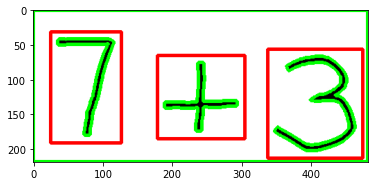

In [89]:
plt.imshow(rect_img)

In [146]:
def overlapping_axes(coord1, delta1, coord2, delta2):
    """Checks wether 2 bounding boxes overlap over given axes
    Args:
        coord1 (int): start coordinate of axes for first bounding box
        delta1 (int): size of first bounding box along axes
        coord2 (int): coordinate of start axes for second bounding box
        delta2 (int): size of second bounding box along axes
    Returns:
        bool: true if they overlap else false
    """
    if coord1 <= coord2 + delta2 and coord1 >= coord2:
        return True
    if coord1 + delta1 <= coord2 + delta2 and coord1 + delta1 >= coord2:
        return True
    if coord2 <= coord1 + delta1 and coord2 >= coord1:
        return True
    if coord2 + delta2 <= coord1 + delta1 and coord2 + delta2 >= coord1:
        return True

    return False

In [199]:
def remove_overlapping_bounding_boxes(boundingRects):
    """Finds all contours and chooses ones that best contour given characters.
    Args:
        boundingRects (list): list of bounding boxes to check and remove if overlapping
    Returns:
        list: list of bounding boxes for filtered contours
    """

    # If 2 bounding boxes are overlapping, take the bigger one
    for i in range(len(boundingRects)):
        if boundingRects[i] is None:
            continue
        for j in range(i + 1, len(boundingRects)):
            if boundingRects[j] is None:
                continue
            x1, y1, width1, height1 = boundingRects[i]
            x2, y2, width2, height2 = boundingRects[j]

            if overlapping_axes(x1, width1, x2, width2) and overlapping_axes(y1, height1, y2, height2):
                if width1 * height1 > width2 * height2:
                    boundingRects[j] = None
                else:
                    boundingRects[i] = None
                    break

    return [bounding for bounding in boundingRects if bounding is not None]

In [95]:
def crop_bounding_box(image, bounding_boxes):
    """Crops images given their bounding boxes
    Args:
        image (np.ndarray): np.ndarray representation of the image
        bounding_boxes (list): bounding box to be used for cropping
    Returns:
        np.ndarray: np.ndarray representation of the cropped image
    """
    cropped_images = list()
    
    for i in range(0, len(bounding_boxes)):
        x, y, w, h = bounding_boxes[i]
        cropped_image = image[(y-10):(y+h+10), (x-10):(x+w+10)]
        cropped_images.append(cropped_image)
    
    return cropped_images

In [96]:
cropped_imgs = crop_bounding_box(image, boundingRects)

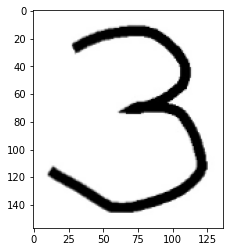

In [100]:
plt.imshow(cropped_imgs[2])

In [77]:
# define a function that will resize images to predetermined standard size, which is 150x150 in our case

def resize_images(images_list, pixels_height = 150, pixels_width = 150):
    """This function resizes all images in the given input list to desired 
    pixels height and pixels width.
    
    Args:
        images_list (list): List of images in . 
        pixels_height (int): Desired height of the resized image in pixels.
        pixels_width (int): Desired width of the resized image in pixels.
    Returns:
        resized_imgs (list): List of resized images.
    """
    resized_imgs = []
    
    for image in images_list:
        try:
            resized_image = cv.resize(image, (pixels_height, pixels_width))
            resized_imgs.append(resized_image)
        except:
            break
            
    return resized_imgs

In [78]:
resized_images = resize_images(cropped_imgs)

In [79]:
resized_images_array = np.array(resized_images)

# check for expected output
resized_images_array.shape

(3, 150, 150, 3)

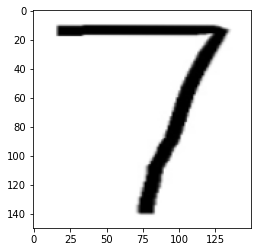

In [83]:
plt.imshow(resized_images[2])

In [101]:
def save_array(numpy_array):
    """This function saves numpy array to a .npy file.
    
    Args:
        numpy_array (ndarray): Array to save in the form of .npy file. 
    """
    np.save(r'output\output_array_1.npy', numpy_array)

In [66]:
save_array(resized_images_array)

In [215]:
"""define a pipeline function that takes all necessary steps to proceess handwritten equation picture 
and prepares it for model prediction"""

def equation_image_preprocess_pipeline(image_path):
    image = cv.imread(image_path)
    
    # find all conours in a given picture
    contours, hierarchy = find_contours(image_path)
    
    # create list of bounding boxes (list of tuples)
    boundingBoxes = [cv.boundingRect(contour) for contour in contours]
    
    # sort list of bounding boxes by first element of tuples (which is x coordinate) 
    boundingBoxes.sort()
    
    # drop first element (bounding box that frames whole image)
    boundingBoxes = boundingBoxes[1:]
    
    # remove overlapping bounding boxes
    boundingBoxes_filtered = remove_overlapping_bounding_boxes(boundingBoxes)
    
    # crop images given their bounding boxes
    cropped_imgs = crop_bounding_box(image, boundingBoxes_filtered)
    
    # resize images to right size for prediction
    resized_images = resize_images(cropped_imgs)
    
    # create an numpy array of resized images
    resized_images_array = np.array(resized_images)
    
    # save numpy array to a .npy file
    save_array(resized_images_array)  

In [261]:
test_image_path = '87+95.jpg'

In [245]:
equation_image_preprocess_pipeline(test_image_path)

### Test

In [262]:
test_image = cv.imread(test_image_path)
test_image_copy = test_image.copy()
test_image_copy_2 = test_image.copy()

In [263]:
contours, hierarchy = find_contours(test_image_path)

In [264]:
boundingBoxes = [cv.boundingRect(contour) for contour in contours]

In [265]:
boundingBoxes.sort()

In [266]:
boundingBoxes = boundingBoxes[1:]

In [267]:
boundingBoxes

[(26, 165, 68, 151),
 (32, 171, 45, 46),
 (51, 226, 37, 82),
 (119, 158, 83, 153),
 (251, 179, 109, 128),
 (393, 145, 88, 160),
 (399, 155, 66, 54),
 (511, 142, 109, 168),
 (566, 6, 2, 2)]

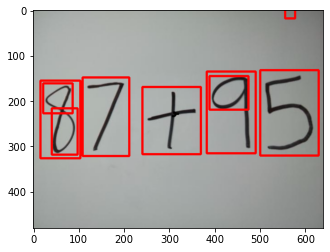

In [283]:
(x, y, w, h) = boundingBoxes[8]

bound_box_img = cv.rectangle(test_image_copy, (x-10, y-10), (x+w+10, y+h+10), (255, 0, 0), 3)

plt.imshow(bound_box_img)

In [276]:
boundingBoxes_filtered = remove_overlapping_bounding_boxes(boundingBoxes)

boundingBoxes_filtered

[(26, 165, 68, 151),
 (119, 158, 83, 153),
 (251, 179, 109, 128),
 (393, 145, 88, 160),
 (511, 142, 109, 168),
 (566, 6, 2, 2)]

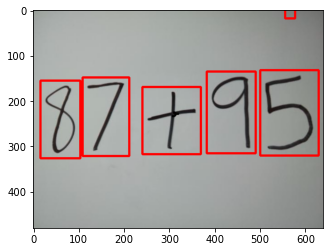

In [282]:
(x, y, w, h) = boundingBoxes_filtered[5]

bound_box_img_2 = cv.rectangle(test_image_copy_2, (x-10, y-10), (x+w+10, y+h+10), (255, 0, 0), 3)

plt.imshow(bound_box_img_2)

In [284]:
cropped_imgs = crop_bounding_box(test_image, boundingBoxes_filtered)

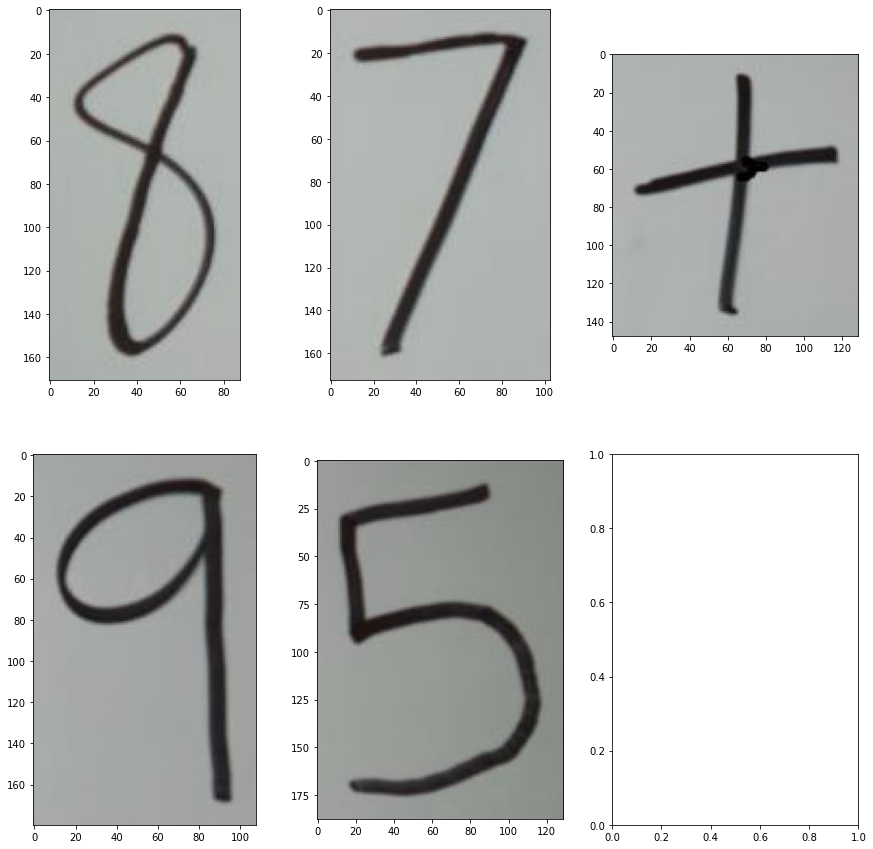

In [292]:
# inspect images
rows=2
cols = 3
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

for i in range(rows):
    for j in range(cols):        
        if img_count < 5:
            axes[i, j].imshow(cropped_imgs[img_count])
            img_count+=1

In [285]:
resized_images = resize_images(cropped_imgs)

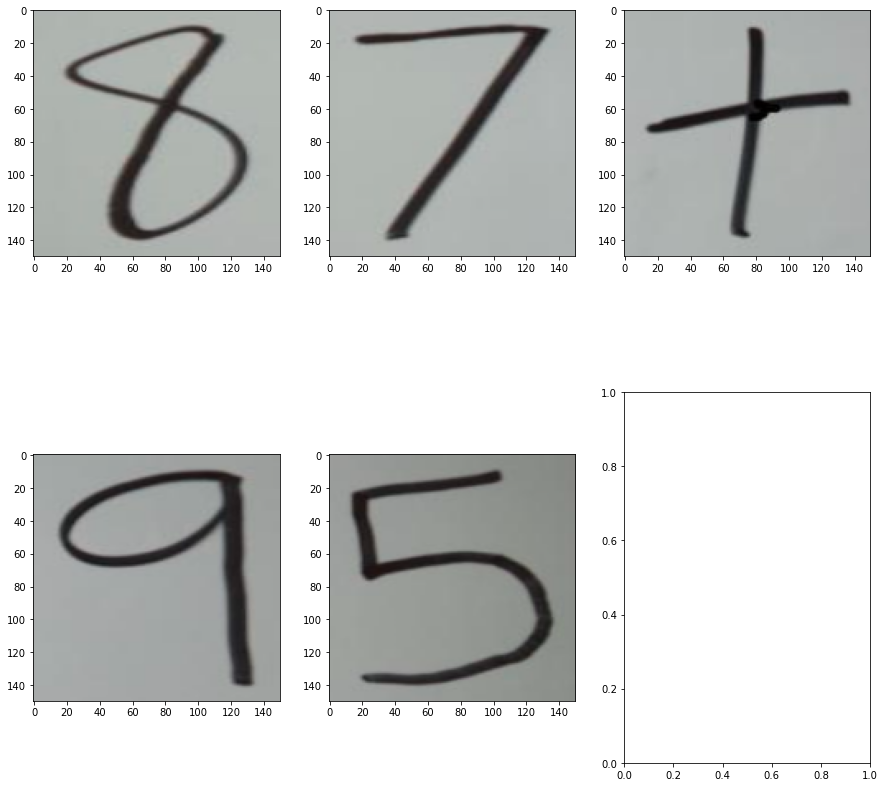

In [293]:
# inspect images
rows=2
cols = 3
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

for i in range(rows):
    for j in range(cols):        
        if img_count < 5:
            axes[i, j].imshow(resized_images[img_count])
            img_count+=1